## DEAD

Fitting a model (or two) based on our proposal.

- **Goal:** Build a model to predict sales in a month for any given store.
- **Response Variable:** Monthly Sales
- **Possible Features:** store, month, county, population stuff, proximity stuff, alcohol categories

In [201]:
import duckdb as db 
con = db.connect()
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [202]:
# MAIN TABLE
con.execute("""
        DROP TABLE IF EXISTS sales;
        CREATE TABLE sales AS 
        SELECT EXTRACT(MONTH FROM date) AS month, EXTRACT (YEAR FROM date) AS year,
            store, city, county, 
            category_name AS category, sale_bottles AS bottles, sale_dollars AS dollars
        FROM read_parquet('../data/iowa_liquor_2023_2025.parquet');
""")
sales = con.execute("SELECT * FROM sales").df()

# POPULATION
con.execute(
"""
        DROP TABLE IF EXISTS population;
        CREATE TABLE population AS
        SELECT name AS county, year_1 AS year, popestimate AS population, over21, propOver21, median_age_tot AS median_age, (POPEST_MALE / (POPEST_FEM + POPEST_MALE)) AS pct_male
        FROM read_csv_auto('../data/pop.csv');
"""
)
pop = con.execute("SELECT * FROM population").df()

# PROXIMITY
con.execute(
"""
        DROP TABLE IF EXISTS proximity;
        CREATE TABLE proximity AS
        SELECT county
        FROM read_csv_auto('../data/proximity.csv');
"""
)
prox = con.execute("SELECT * FROM proximity").df()




In [203]:
#Reading in socioeconomic data
socioeconomic = pd.read_csv("../data/HDPulse_socioeconomic_data.csv")

socioeconomic["County"] = socioeconomic["County"].str.replace(r"\s+County$", "", regex=True)
socioeconomic.rename(columns={
    "County": "county",
    "FIPS": "fips",
    "% People (Education: Less Than 9th Grade)": "pct_less_than_9th_grade",
    "People (Education: Less Than 9th Grade)": "less_than_9th_grade",
    "% People (Unemployed)": "pct_unemployed",
    "People (Unemployed)": "unemployed",
    "% People (Below Poverty)": "pct_below_poverty",
    "People (Below Poverty)": "below_poverty",
    "% People (<150% Of Poverty)": "pct_below_150pct_poverty",
    "People (<150% Of Poverty)": "below_150pct_poverty",
    "% Families (Below Poverty)": "pct_families_below_poverty",
    "Families (Below Poverty)": "families_below_poverty",
    "% People (White)": "pct_white",
    "People (White)": "white",
    "% People (Hispanic)": "pct_hispanic",
    "People (Hispanic)": "hispanic",
    "% People (Foreign Born)": "pct_foreign_born",
    "People (Foreign Born)": "foreign_born",
    "% People (Black)": "pct_black",
    "People (Black)": "black",
    "% People (API)": "pct_api",
    "People (API)": "api",
    "% People (AI/AN)": "pct_aian",
    "People (AI/AN)": "aian",
    "% Households (language Isolation)": "pct_language_isolation",
    "Households (language Isolation)": "language_isolation",
    "% People(Education: Less Than High School)": "pct_less_than_high_school",
    "People(Education: Less Than High School)": "less_than_high_school",
    "% People (Education: At Least Bachelor's Degree)": "pct_at_bachelor_degree"
}, inplace=True)
socioeconomic.head()

,county,fips,pct_less_than_9th_grade,less_than_9th_grade,pct_unemployed,unemployed,pct_below_poverty,below_poverty,pct_below_150pct_poverty,below_150pct_poverty,pct_families_below_poverty,families_below_poverty,pct_white,white,pct_hispanic,hispanic,pct_foreign_born,foreign_born,pct_black,black,pct_api,api,pct_aian,aian,pct_language_isolation,language_isolation,pct_less_than_high_school,less_than_high_school,pct_at_bachelor_degree
0,Adair,19001.0,2.1,110.0,4.2,162.0,10.3,753.0,21.8,1591.0,5.0,92.0,94.9,7091.0,2.9,214.0,1.6,120.0,1.4,101.0,0.5,34.0,0.4,27.0,0.0,0.0,5.5,287.0,20.0
1,Adams,19003.0,2.6,68.0,2.9,53.0,9.5,339.0,17.7,629.0,3.6,35.0,95.4,3475.0,0.7,27.0,0.2,9.0,0.4,13.0,0.0,0.0,0.5,20.0,0.3,5.0,7.4,197.0,24.5
2,Allamakee,19005.0,3.0,293.0,3.6,252.0,12.1,1657.0,19.8,2716.0,9.4,350.0,90.4,12690.0,8.7,1225.0,6.7,937.0,1.8,246.0,0.5,76.0,0.8,115.0,4.4,265.0,7.5,721.0,19.9
3,Appanoose,19007.0,5.5,480.0,6.9,375.0,20.4,2468.0,31.9,3851.0,10.8,346.0,95.1,11641.0,1.7,212.0,1.2,150.0,1.0,121.0,0.4,53.0,0.1,7.0,1.0,51.0,10.3,907.0,19.3
4,Audubon,19009.0,2.7,108.0,1.9,52.0,11.8,649.0,20.9,1147.0,7.1,109.0,95.2,5351.0,2.0,115.0,0.9,48.0,0.3,15.0,0.1,7.0,0.2,12.0,0.9,23.0,8.0,322.0,20.6


In [204]:
#aggregating the 2 education statistics
socioeconomic["pct_high_school_lower"] = socioeconomic["pct_less_than_high_school"] + socioeconomic["pct_less_than_9th_grade"]

In [205]:
prox = pd.DataFrame(prox.value_counts())
prox.rename(columns={'count': 'store_count'}, inplace=True)
prox.reset_index(inplace=True)
prox.head()

,county,store_count
0,POLK,317
1,LINN,168
2,SCOTT,112
3,BLACK HAWK,108
4,JOHNSON,93


## Creating the Dataset

First, I am going to engineer the category column a little bit to use as features. Knowing which alcohol sells the best is could be useful for telling Booze R Us what they should buy in order to increase profits.

In [206]:
con.execute("""
    CREATE OR REPLACE TABLE sales AS
    SELECT *,
        CASE
            WHEN category ILIKE '%VODKA%' THEN 'Vodka'
            WHEN category ILIKE '%WHISK%' THEN 'Whiskey'
            WHEN category ILIKE '%TEQUILA%' OR category ILIKE '%MEZCAL%' THEN 'Tequila'
            WHEN category ILIKE '%RUM%' THEN 'Rum'
            ELSE 'Other'
        END AS super_category
    FROM sales
""")
sales = con.execute("SELECT * FROM sales").df()

In [207]:
sales.head()

,month,year,store,city,county,category,bottles,dollars,super_category
0,1,2023,4829,DES MOINES,POLK,100% AGAVE TEQUILA,12,261.00,Tequila
1,1,2023,4829,DES MOINES,POLK,AMERICAN VODKAS,60,418.80,Vodka
2,1,2023,4829,DES MOINES,POLK,IMPORTED FLAVORED VODKA,24,358.56,Vodka
3,1,2023,4829,DES MOINES,POLK,CREAM LIQUEURS,12,306.00,Other
4,1,2023,4829,DES MOINES,POLK,SPICED RUM,60,1124.40,Rum


Now I need to agreggate to create our appropriate observational units: monthly sales per store.

- Dollars (our response variable) will be summed. 
- Category will be made into new columns representing the distribution of category sales
    - e.g. 70% tequila, 20% vodkas, etc.
    - we will not use total bottles because this would be almost perfectly collinear 
    - answer questions like: 'what liquor should we sell more/less of?'

In [208]:
monthly_sales = con.execute(
"""
    WITH month_totals AS (
        SELECT
            year,
            month,
            county,
            SUM(dollars) AS revenue
        FROM sales
        GROUP BY year, month, county
    ), category_totals AS (
        SELECT
            year,
            month,
            county,
            super_category,
            SUM(dollars) AS category_sales
        FROM sales
        GROUP BY year, month, county, super_category
    )
    SELECT
        mt.year,
        mt.month,
        mt.county,
        ROUND(SUM(CASE WHEN ct.super_category = 'Vodka' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS vodka_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Whiskey' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS whiskey_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Tequila' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS tequila_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Rum' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS rum_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Other' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS other_ptc,
        mt.revenue
    FROM month_totals mt
    LEFT JOIN category_totals ct
        ON mt.year = ct.year
        AND mt.month = ct.month
        AND mt.county = ct.county
    GROUP BY mt.year, mt.month, mt.county, mt.revenue
"""
).fetchdf()


In [209]:
monthly_sales.head(2)

,year,month,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue
0,2023,3,FLOYD,0.19,0.36,0.07,0.16,0.22,111882.89
1,2023,3,BREMER,0.21,0.42,0.05,0.13,0.19,173736.94


Now I will join with our other datasets, proximity and population. Using an inner join because it still leaves plenty of complete data for modelling. 

In [210]:
df = con.execute(
    """
        SELECT sales.*, 
            pop.population, pop.over21, pop.propOver21, pop.median_age, pop.pct_male, prox.store_count, socioeconomic.*
        FROM monthly_sales sales
        JOIN pop
            ON LOWER(sales.county) = LOWER(pop.county) AND sales.year = pop.year
        JOIN prox
            on LOWER(pop.county) = LOWER(prox.county)
        JOIN socioeconomic
            on LOWER(pop.county) = LOWER(socioeconomic.county)

        
    """
    ).fetchdf()

Now encode month to use as a categorical feature:

In [211]:
months = pd.get_dummies(df.month, prefix='month', drop_first=True)
df = pd.concat([df.drop(columns='month'), months], axis=1)
df.head()

,year,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,population,over21,propOver21,median_age,pct_male,store_count,county_1,fips,pct_less_than_9th_grade,less_than_9th_grade,pct_unemployed,unemployed,pct_below_poverty,below_poverty,pct_below_150pct_poverty,below_150pct_poverty,pct_families_below_poverty,families_below_poverty,pct_white,white,pct_hispanic,hispanic,pct_foreign_born,foreign_born,pct_black,black,pct_api,api,pct_aian,aian,pct_language_isolation,language_isolation,pct_less_than_high_school,less_than_high_school,pct_at_bachelor_degree,pct_high_school_lower,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2023,FLOYD,0.19,0.36,0.07,0.16,0.22,111882.89,15266,11772,0.771125,43.1,0.499607,11,Floyd,19067.0,2.6,282.0,3.5,273.0,11.4,1742.0,19.4,2973.0,6.7,263.0,90.4,14009.0,3.7,579.0,3.1,486.0,1.2,185.0,1.7,257.0,0.0,6.0,0.8,51.0,5.3,576.0,18.5,7.9,False,True,False,False,False,False,False,False,False,False,False
1,2023,BREMER,0.21,0.42,0.05,0.13,0.19,173736.94,25304,19650,0.776557,39.8,0.500356,16,Bremer,19017.0,1.0,174.0,3.6,471.0,7.5,1767.0,13.6,3220.0,4.1,266.0,93.2,23406.0,2.0,502.0,1.6,401.0,1.1,283.0,1.0,258.0,0.1,18.0,0.1,13.0,4.1,686.0,35.2,5.1,False,True,False,False,False,False,False,False,False,False,False
2,2023,LYON,0.15,0.49,0.04,0.12,0.20,86868.39,12288,8886,0.723145,38.1,0.513428,14,Lyon,19119.0,2.6,201.0,2.4,145.0,5.3,634.0,13.3,1588.0,3.1,100.0,94.6,11429.0,3.5,421.0,1.7,204.0,0.3,36.0,0.4,54.0,0.0,6.0,0.5,20.0,4.6,356.0,14.5,7.2,False,True,False,False,False,False,False,False,False,False,False
3,2023,HANCOCK,0.26,0.45,0.03,0.09,0.17,60634.91,10631,8343,0.784780,43.9,0.505785,8,Hancock,19081.0,1.6,125.0,2.2,124.0,12.1,1272.0,16.9,1772.0,8.0,251.0,93.7,10045.0,5.8,620.0,2.4,255.0,0.9,94.0,0.6,69.0,0.1,12.0,0.4,18.0,8.4,649.0,21.4,10.0,False,True,False,False,False,False,False,False,False,False,False
4,2023,FREMONT,0.22,0.54,0.01,0.06,0.17,15867.26,6458,5047,0.781511,45.5,0.501239,4,Fremont,19071.0,1.6,75.0,1.0,30.0,7.6,489.0,16.3,1050.0,5.2,92.0,93.5,6141.0,3.2,213.0,1.4,93.0,0.6,41.0,0.2,13.0,0.0,3.0,0.9,24.0,5.0,237.0,21.1,6.6,False,True,False,False,False,False,False,False,False,False,False


In [212]:
#saving data
df = df.copy()
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df = df[df['revenue'] > 0]   
df.to_csv('../data/dead_model_data.csv', index=False)

## Linear Regression (from scratch)

First, the function to fit the model. It will take observed X and Y matrices and return the predictions and estimators.

In [213]:
def fit_lr(X, Y):
    
    X = np.column_stack([np.ones((X.shape[0], 1)), X.astype(float)]) # add column of ones
    B = np.linalg.pinv(X.T @ X) @ X.T @ Y

    return B

In [214]:
def predict_lr(X, B):
    
    X = np.column_stack([np.ones((X.shape[0], 1)), X.astype(float)]) # add column of ones
    Y_hat = X @ B

    return Y_hat

A cross validation function:

In [215]:
def lr_cross_val(data, features, response, k=5):

    # make k folds
    n = data.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // k
    folds = [indices[i*fold_size:(i+1)*fold_size] for i in range(k-1)]
    folds.append(indices[(k-1)*fold_size:])  # last fold gets the remainder

    # loop over folds and store their predictions
    predictions = np.zeros(n)
    for fold_idx in folds:
        # training indices = everything not in this fold
        train_idx = np.setdiff1d(indices, fold_idx)
        test_idx = fold_idx

        train = data.iloc[train_idx]
        test = data.iloc[test_idx]

        # fit model
        B = fit_lr(train[features].values, train[response].values)

        # predict on test set
        Y_hat = predict_lr(test[features].values, B)

        predictions[test_idx] = Y_hat
    return predictions



Fit the model:

- *NOTE:* I first fit with all possible features, then after assessing model fit, feature importance, and multicollinearity (all below), I came back up and changed the features. So this is just the final model here, not all iterations.

In [216]:
#adding additional variables
df["store_ratio"] = df["store_count"] / df["population"]
df['log_revenue_per_person'] = np.log(df['revenue'] / df['population'])

In [217]:
df.head()

,year,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,population,over21,propOver21,median_age,pct_male,store_count,county_1,fips,pct_less_than_9th_grade,less_than_9th_grade,pct_unemployed,unemployed,pct_below_poverty,below_poverty,pct_below_150pct_poverty,below_150pct_poverty,pct_families_below_poverty,families_below_poverty,pct_white,white,pct_hispanic,hispanic,pct_foreign_born,foreign_born,pct_black,black,pct_api,api,pct_aian,aian,pct_language_isolation,language_isolation,pct_less_than_high_school,less_than_high_school,pct_at_bachelor_degree,pct_high_school_lower,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,store_ratio,log_revenue_per_person
0,2023,FLOYD,0.19,0.36,0.07,0.16,0.22,111882.89,15266,11772,0.771125,43.1,0.499607,11,Floyd,19067.0,2.6,282.0,3.5,273.0,11.4,1742.0,19.4,2973.0,6.7,263.0,90.4,14009.0,3.7,579.0,3.1,486.0,1.2,185.0,1.7,257.0,0.0,6.0,0.8,51.0,5.3,576.0,18.5,7.9,False,True,False,False,False,False,False,False,False,False,False,0.000721,1.991825
1,2023,BREMER,0.21,0.42,0.05,0.13,0.19,173736.94,25304,19650,0.776557,39.8,0.500356,16,Bremer,19017.0,1.0,174.0,3.6,471.0,7.5,1767.0,13.6,3220.0,4.1,266.0,93.2,23406.0,2.0,502.0,1.6,401.0,1.1,283.0,1.0,258.0,0.1,18.0,0.1,13.0,4.1,686.0,35.2,5.1,False,True,False,False,False,False,False,False,False,False,False,0.000632,1.926580
2,2023,LYON,0.15,0.49,0.04,0.12,0.20,86868.39,12288,8886,0.723145,38.1,0.513428,14,Lyon,19119.0,2.6,201.0,2.4,145.0,5.3,634.0,13.3,1588.0,3.1,100.0,94.6,11429.0,3.5,421.0,1.7,204.0,0.3,36.0,0.4,54.0,0.0,6.0,0.5,20.0,4.6,356.0,14.5,7.2,False,True,False,False,False,False,False,False,False,False,False,0.001139,1.955771
3,2023,HANCOCK,0.26,0.45,0.03,0.09,0.17,60634.91,10631,8343,0.784780,43.9,0.505785,8,Hancock,19081.0,1.6,125.0,2.2,124.0,12.1,1272.0,16.9,1772.0,8.0,251.0,93.7,10045.0,5.8,620.0,2.4,255.0,0.9,94.0,0.6,69.0,0.1,12.0,0.4,18.0,8.4,649.0,21.4,10.0,False,True,False,False,False,False,False,False,False,False,False,0.000753,1.741097
4,2023,FREMONT,0.22,0.54,0.01,0.06,0.17,15867.26,6458,5047,0.781511,45.5,0.501239,4,Fremont,19071.0,1.6,75.0,1.0,30.0,7.6,489.0,16.3,1050.0,5.2,92.0,93.5,6141.0,3.2,213.0,1.4,93.0,0.6,41.0,0.2,13.0,0.0,3.0,0.9,24.0,5.0,237.0,21.1,6.6,False,True,False,False,False,False,False,False,False,False,False,0.000619,0.898938


Fit the model:

- *NOTE:* I first fit with all possible features, then after assessing model fit, feature importance, and multicollinearity (all below), I came back up and changed the features. So this is just the final model here, not all iterations.

In [218]:
# 'all features for final model
features = ['vodka_ptc', 'whiskey_ptc', 'tequila_ptc', 'rum_ptc',
        'propOver21',
       'median_age', 'pct_male', 'pct_at_bachelor_degree',
        'pct_unemployed',
       'pct_below_poverty', 'pct_high_school_lower',
       'pct_families_below_poverty',
       'pct_hispanic', 'pct_foreign_born',
       'pct_black', 'pct_api', 'pct_aian',
       'pct_language_isolation',
       'month_5', 'month_6',
'month_11']
response = 'log_revenue_per_person'

# fit
Yhat = lr_cross_val(df, features, response, k=5)

 Assess model fit:

In [219]:
Y = df[response].values
X = df[features].values
RSS = np.sum((Y - Yhat)**2)
TSS = np.sum((Y - np.mean(Y))**2)
R2 = 1 - RSS/TSS
n, p = X.shape  # after adding intercept
adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p)
MAE = np.mean(np.abs(Y - Yhat))
RMSE = np.sqrt(RSS / n)

print(f"R2 = {R2:.4f}")
print(f"Adjusted R2 = {adj_R2:.4f}")
print(f"MAE = {MAE:.2f}")
print(f"RMSE = {RMSE:.2f}")

R2 = 0.4782
Adjusted R2 = 0.4735
MAE = 0.29
RMSE = 0.37


In [220]:
# fit a final model on all the data
X = df[features]
Y = df[response]
B_final = fit_lr(X, Y)

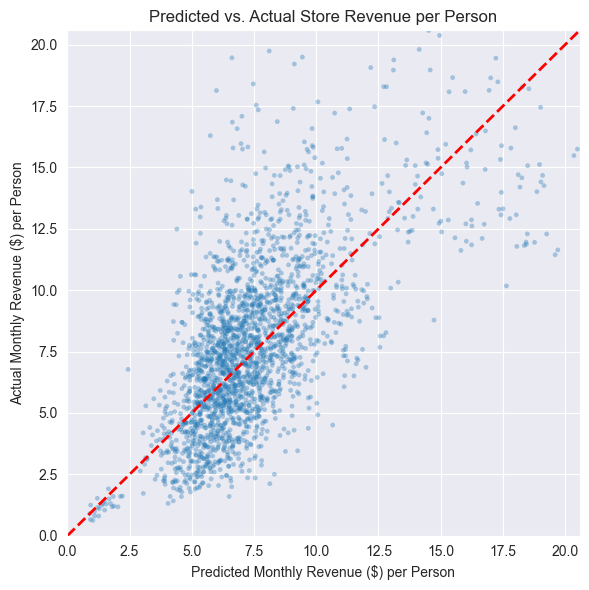

In [221]:
#predict after final fit
y_pred = predict_lr(X, B_final)
# 1) align CV preds to the df rows
df['predicted_log_revenue_per_person'] = y_pred

# 2) keep only rows with OOF predictions
mask = df['predicted_log_revenue_per_person'].notna()
df["revenue_per_person"] = df["revenue"] / df["population"]

# 3) back-transform predictions to dollars (BASE-e)
predicted_revenue = np.power(np.e, df.loc[mask, 'predicted_log_revenue_per_person'].to_numpy())
actual_revenue    = df.loc[mask, 'revenue_per_person'].to_numpy()  # already in dollars


plt.figure(figsize=(6,6))
plt.scatter(predicted_revenue, actual_revenue, alpha=0.35, s=12, edgecolor='none')
plt.plot([0, actual_revenue.max()/3], [0, actual_revenue.max()/3], 'r--', lw=2)
plt.xlim(0, actual_revenue.max()/3)
plt.ylim(0, actual_revenue.max()/3)
plt.xlabel('Predicted Monthly Revenue ($) per Person')
plt.ylabel('Actual Monthly Revenue ($) per Person')
plt.title('Predicted vs. Actual Store Revenue per Person')
plt.tight_layout()
plt.show()

In [222]:
#betas of each feature
coef_names = ['intercept'] + list(X.columns)
nonstd_df = pd.DataFrame({
    'feature': coef_names,
    'beta': B_final
})
nonstd_df = nonstd_df[nonstd_df['feature'] != 'intercept']
nonstd_df = nonstd_df.reindex(
    nonstd_df['beta'].abs().sort_values(ascending=False).index
)
print(nonstd_df)

                       feature      beta
7                     pct_male -8.996828
3                  tequila_ptc  3.157305
1                    vodka_ptc -3.085349
2                  whiskey_ptc -2.391064
5                   propOver21 -0.561536
19                     month_5  0.133457
4                      rum_ptc  0.092160
16                     pct_api  0.084446
20                     month_6  0.070746
14            pct_foreign_born -0.061278
15                   pct_black  0.050090
11       pct_high_school_lower -0.043419
13                pct_hispanic  0.037040
17                    pct_aian -0.035722
18      pct_language_isolation  0.027759
10           pct_below_poverty  0.024770
9               pct_unemployed  0.020993
6                   median_age  0.017727
21                    month_11  0.016062
12  pct_families_below_poverty -0.009470
8       pct_at_bachelor_degree -0.002179


Check standardized coefficients because their magnitudes actually tell us importance:

In [223]:
#importance of each feature
X_std = X.apply(pd.to_numeric, errors='coerce').astype(float).std(axis=0, ddof=0).to_numpy()
Y_std = pd.to_numeric(Y, errors='coerce').astype(float).std(ddof=0)
beta_no_intercept = np.ravel(B_final[1:])  # shape (p,)
std_beta = beta_no_intercept * (X_std / Y_std)
importance = (pd.DataFrame({"feature": X.columns, "std_coef": std_beta})
              .sort_values("std_coef", key=np.abs, ascending=False)
              .reset_index(drop=True))

print(importance)


                       feature  std_coef
0        pct_high_school_lower -0.398800
1                 pct_hispanic  0.376535
2             pct_foreign_born -0.375443
3                  whiskey_ptc -0.294434
4                    vodka_ptc -0.254878
5                      pct_api  0.216244
6                  tequila_ptc  0.179343
7            pct_below_poverty  0.157438
8                    pct_black  0.152925
9                     pct_male -0.149137
10                  median_age  0.110986
11      pct_language_isolation  0.079797
12                     month_5  0.071418
13                    pct_aian -0.049989
14  pct_families_below_poverty -0.049262
15              pct_unemployed  0.045330
16                     month_6  0.037859
17      pct_at_bachelor_degree -0.032563
18                  propOver21 -0.023655
19                    month_11  0.008595
20                     rum_ptc  0.007189


Check for collinearity between features:

In [224]:
# compute correlation matrix for numeric features
corr = X.corr().abs()

# show only the top correlated pairs
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
print("Most correlated feature pairs:\n")
print(high_corr.head(10))


Most correlated feature pairs:

pct_foreign_born       pct_language_isolation        0.823051
pct_hispanic           pct_foreign_born              0.821608
pct_below_poverty      pct_families_below_poverty    0.817360
pct_hispanic           pct_language_isolation        0.792529
pct_foreign_born       pct_api                       0.723608
pct_black              pct_api                       0.693088
median_age             pct_api                       0.614981
tequila_ptc            pct_black                     0.564935
pct_high_school_lower  pct_language_isolation        0.551970
pct_foreign_born       pct_black                     0.542230
dtype: float64
